# **Estratificacion del dengue en el departamento del Cauca, Colombia**

En este proyecto, trabajaremos con los siguientes datasets

- `entomologico.csv` : Contiene registros de muestras de insectos recolectados en diferentes localidades del departamento del Cauca, en donde cada registro tiene informacion sobre el numero de individuos, genero, especie, fecha y lugar de recoleccion.

In [30]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr

plt.style.use('ggplot')


In [31]:

df_entomologico = pd.read_csv('../data/entomologico.csv')

In [32]:
df_entomologico = pd.read_csv('../data/entomologico.csv')
df_cases = pd.read_csv('../data/cases.csv')

def read_as_df(file_name):
    # Read file
    ds = xr.open_dataset(file_name)
    # Convert to dataframe
    df = ds.to_dataframe()

    # Unstack index (coorfinates)
    ## Get position of the coorfinates in index
    coordinates = ['lat', 'lon']
    ## For each coordinate, reset index:
    for coordinate in coordinates:
        position_index = df.index.names.index(coordinate)
        #print(position_index)
        df = df.reset_index(position_index)
    
    return df


df_humedad_relativa = read_as_df("../data/humedad-relativa.nc").reset_index()
df_precipitacion = read_as_df("../data/precipitacion.nc").reset_index()
df_temp_max = read_as_df("../data/temp-maxima.nc").reset_index()
df_temp_min = read_as_df("../data/temp-minima.nc").reset_index()

In [33]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

def group_by_coordinates(df, value_column, sort_ascending=False):
    return df.groupby(['lon', 'lat']).agg({
        value_column: 'mean'
    }).reset_index().sort_values(value_column, ascending=sort_ascending)
    
def plot_geographic_variables(dataframes, value_columns, titles, cmaps=None):
    if cmaps is None:
        cmaps = ['coolwarm'] * len(dataframes)
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, len(dataframes), figsize=(14, 4))
    
    # If only one dataframe is provided, axes will not be an array
    if len(dataframes) == 1:
        axes = [axes]
    
    for i, (df, value_column, title, cmap) in enumerate(zip(dataframes, value_columns, titles, cmaps)):
        # Create geometry points
        geometry = [Point(lon, lat) for lon, lat in zip(df['lon'], df['lat'])]
        
        # Create GeoDataFrame
        gdf = gpd.GeoDataFrame(df, geometry=geometry)
        
        # Plot on the corresponding subplot
        gdf.plot(ax=axes[i], column=value_column, cmap=cmap, legend=True,
            legend_kwds={'label': f"Average {value_column.replace('_', ' ').title()}",
                'orientation': "horizontal"})
        
        axes[i].set_title(title)
        axes[i].set_xlabel('Longitud')
        axes[i].set_ylabel('Latitud')
    
    plt.tight_layout()
    return fig, axes

## **Análisis de diversidad de especies**

###  **Cantidad de ejemplares por especie**

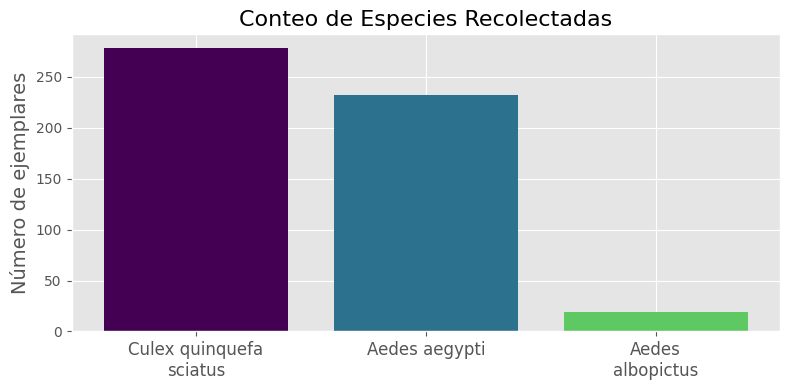


Distribución de especies:


,scientificName,Cantidad,Porcentaje
0,Culex quinquefasciatus,278,52.55
1,Aedes aegypti,232,43.86
2,Aedes albopictus,19,3.59


In [34]:
sc = df_entomologico['scientificName'].value_counts()
fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(sc.index, sc.values, color=plt.cm.viridis(np.linspace(0, 0.75, len(sc))))

ax.set_title('Conteo de Especies Recolectadas', fontsize=16)
ax.set_ylabel('Número de ejemplares', fontsize=14)

from textwrap import wrap
labels = ['\n'.join(wrap(l, 15)) for l in sc.index]

ax.set_xticks(range(len(sc.index)))
ax.set_xticklabels(labels, rotation=0, fontsize=12)

plt.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()

# Mostrar tabla con porcentajes
sc_percent = pd.DataFrame({
    'Cantidad': sc.values,
    'Porcentaje': np.round((sc.values / sc.values.sum()) * 100, 2)
}, index=sc.index).sort_values('Cantidad', ascending=False).reset_index()

print('\nDistribución de especies:')
display(sc_percent)

In [35]:
import re

# Create the base location_diversity with summary statistics
location_diversity = df_entomologico.groupby('locality').agg({
    'individualCount': 'count',
    'scientificName': pd.Series.nunique
}).reset_index().rename(columns={
    'individualCount': 'Total de individuos',
    'scientificName': 'Especies únicas',
})

# Standardize the locality names
location_diversity['locality'] = location_diversity['locality'].str.replace(
    r'^Casa ubicada en el barrio (.+) de (.+)$', r'\1 (\2)',
    regex=True
)

# Create a pivot table with counts for each species at each location
species_pivot = df_entomologico.pivot_table(
    index='locality', 
    columns='scientificName', 
    values='individualCount', 
    aggfunc='count',
    fill_value=0
)

# Apply the same locality name standardization to the pivot table
species_pivot.index = species_pivot.index.str.replace(
    r'^Casa ubicada en el barrio (.+) de (.+)$', r'\1 (\2)',
    regex=True
)

# Reset index to prepare for merge
species_pivot = species_pivot.reset_index()

# Merge the two DataFrames
location_diversity = location_diversity.merge(species_pivot, on='locality')

location_diversity = location_diversity.sort_values('Total de individuos', ascending=False)

location_diversity

,locality,Total de individuos,Especies únicas,Aedes aegypti,Aedes albopictus,Culex quinquefasciatus
10,Olaya Herrera (Patía (El Bordo)),94,3,45,6,43
16,Villa los Prados (Piamonte),49,3,7,4,38
5,Fundadores (Piamonte),48,2,11,0,37
8,La Paz (Piamonte),44,3,10,1,33
15,San Antonio (Miranda),41,3,25,1,15
12,Porvenir (Miranda),36,2,20,0,16
7,La Cabaña (Miranda),32,2,26,0,6
13,Postobón (Patía (El Bordo)),28,3,4,2,22
11,Popular (Patía (El Bordo)),26,2,10,0,16
9,Libertador (Patía (El Bordo)),22,3,7,1,14


<Figure size 1800x1400 with 0 Axes>

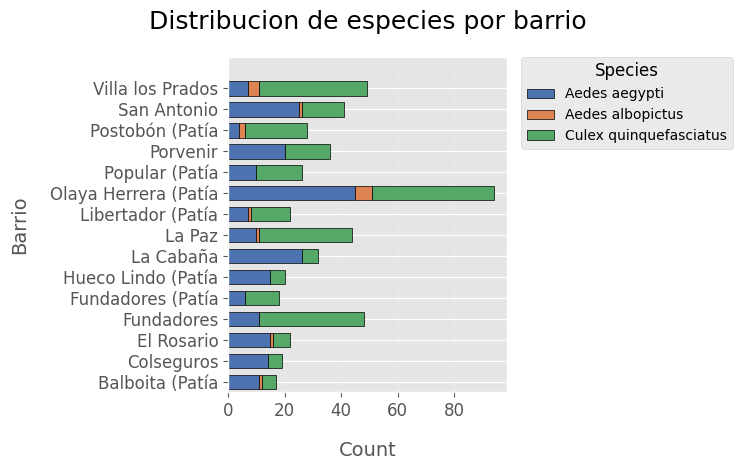

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract Barrio from locality column
location_diversity['Barrio'] = location_diversity['locality'].str.extract(r'(.+) \(', expand=False).str.strip()

# Select only the species columns
species_columns = [col for col in location_diversity.columns 
    if col not in ['locality', 'Total de individuos', 'Especies únicas', 'Barrio']]

# Prepare data for stacked bar chart
melted_data = location_diversity.melt(
    id_vars=['Barrio'],
    value_vars=species_columns,
    var_name='Species',
    value_name='Count'
)

# Get top 15 barrios by total count to reduce clutter
top_barrios = location_diversity.groupby('Barrio')['Total de individuos'].sum().nlargest(15).index
filtered_data = melted_data[melted_data['Barrio'].isin(top_barrios)]

# Create a pivot table with Barrio as index and Species as columns
pivot_data = filtered_data.pivot_table(index='Barrio', columns='Species', values='Count', fill_value=0)

# Set up color palette
colors = sns.color_palette("deep", len(species_columns))

# Create the plot
plt.figure(figsize=(18, 14))  # Increased height to allow for more spacing

# Create the stacked horizontal bar chart - using barh instead of bar
# Reduce width to create spacing between bars
ax = pivot_data.plot(kind='barh', stacked=True, color=colors, width=0.7, edgecolor='black', linewidth=0.5)

# Add more spacing between bars
plt.subplots_adjust(hspace=0.5)

# Enhance the plot
plt.title('Distribucion de especies por barrio', fontsize=18, pad=20)
plt.ylabel('Barrio', fontsize=14, labelpad=15)
plt.xlabel('Count', fontsize=14, labelpad=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# Add grid lines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Move the legend to the right side outside the plot
plt.legend(title='Species', title_fontsize=12, fontsize=10, 
    bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Increase spacing between bars using the y-axis properties
ax.set_ylim(-0.5, len(pivot_data.index) - 0.5 + 1)  # Add extra space

# Ensure the layout is not cut off
plt.tight_layout()
plt.subplots_adjust(right=0.8)

# Show the plot
plt.show()

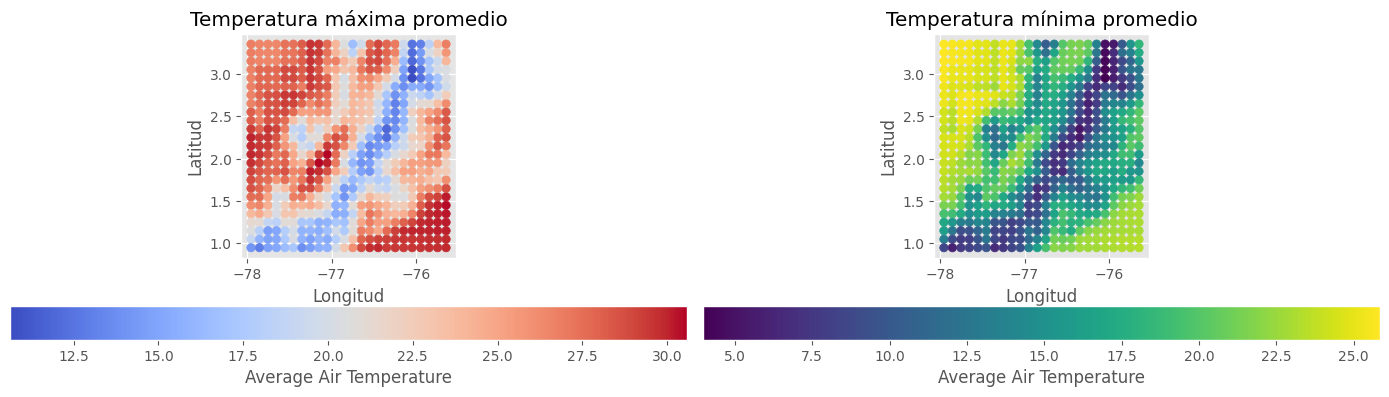

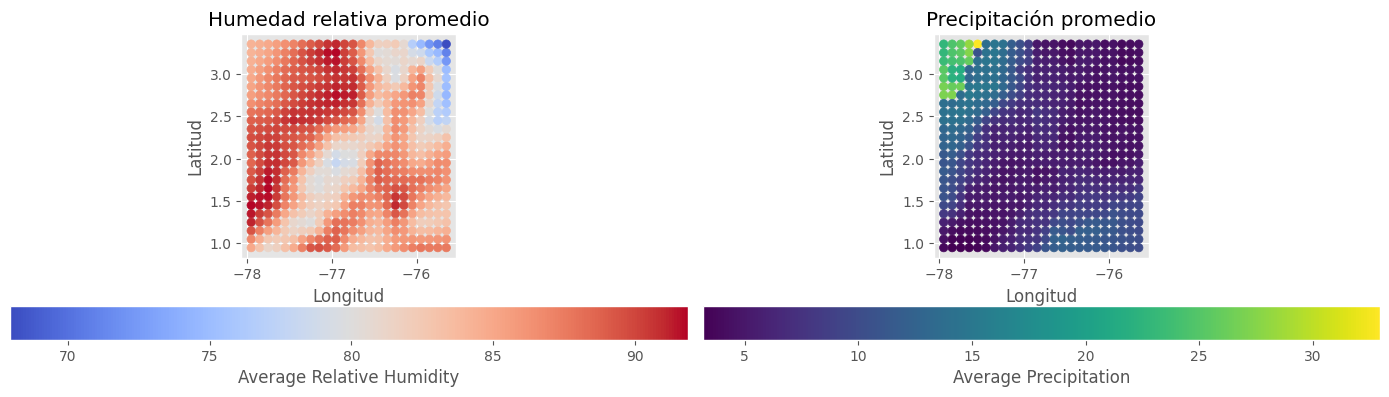

In [37]:
df_humedad_relativa_grouped = group_by_coordinates(df_humedad_relativa, 'relative_humidity')
df_precipitacion_grouped = group_by_coordinates(df_precipitacion, 'precipitation')
df_temp_max_grouped = group_by_coordinates(df_temp_max, 'air_temperature')
df_temp_min_grouped = group_by_coordinates(df_temp_min, 'air_temperature')

plot_geographic_variables(
    dataframes=[df_temp_max_grouped, df_temp_min_grouped],
    value_columns=['air_temperature', 'air_temperature'],
    titles=['Temperatura máxima promedio', 'Temperatura mínima promedio'],
    cmaps=['coolwarm', 'viridis']
)

plt.show()

plot_geographic_variables(
    dataframes=[df_humedad_relativa_grouped, df_precipitacion_grouped],
    value_columns=['relative_humidity', 'precipitation'],
    titles=['Humedad relativa promedio', 'Precipitación promedio'],
    cmaps=['coolwarm', 'viridis']
)

plt.show()

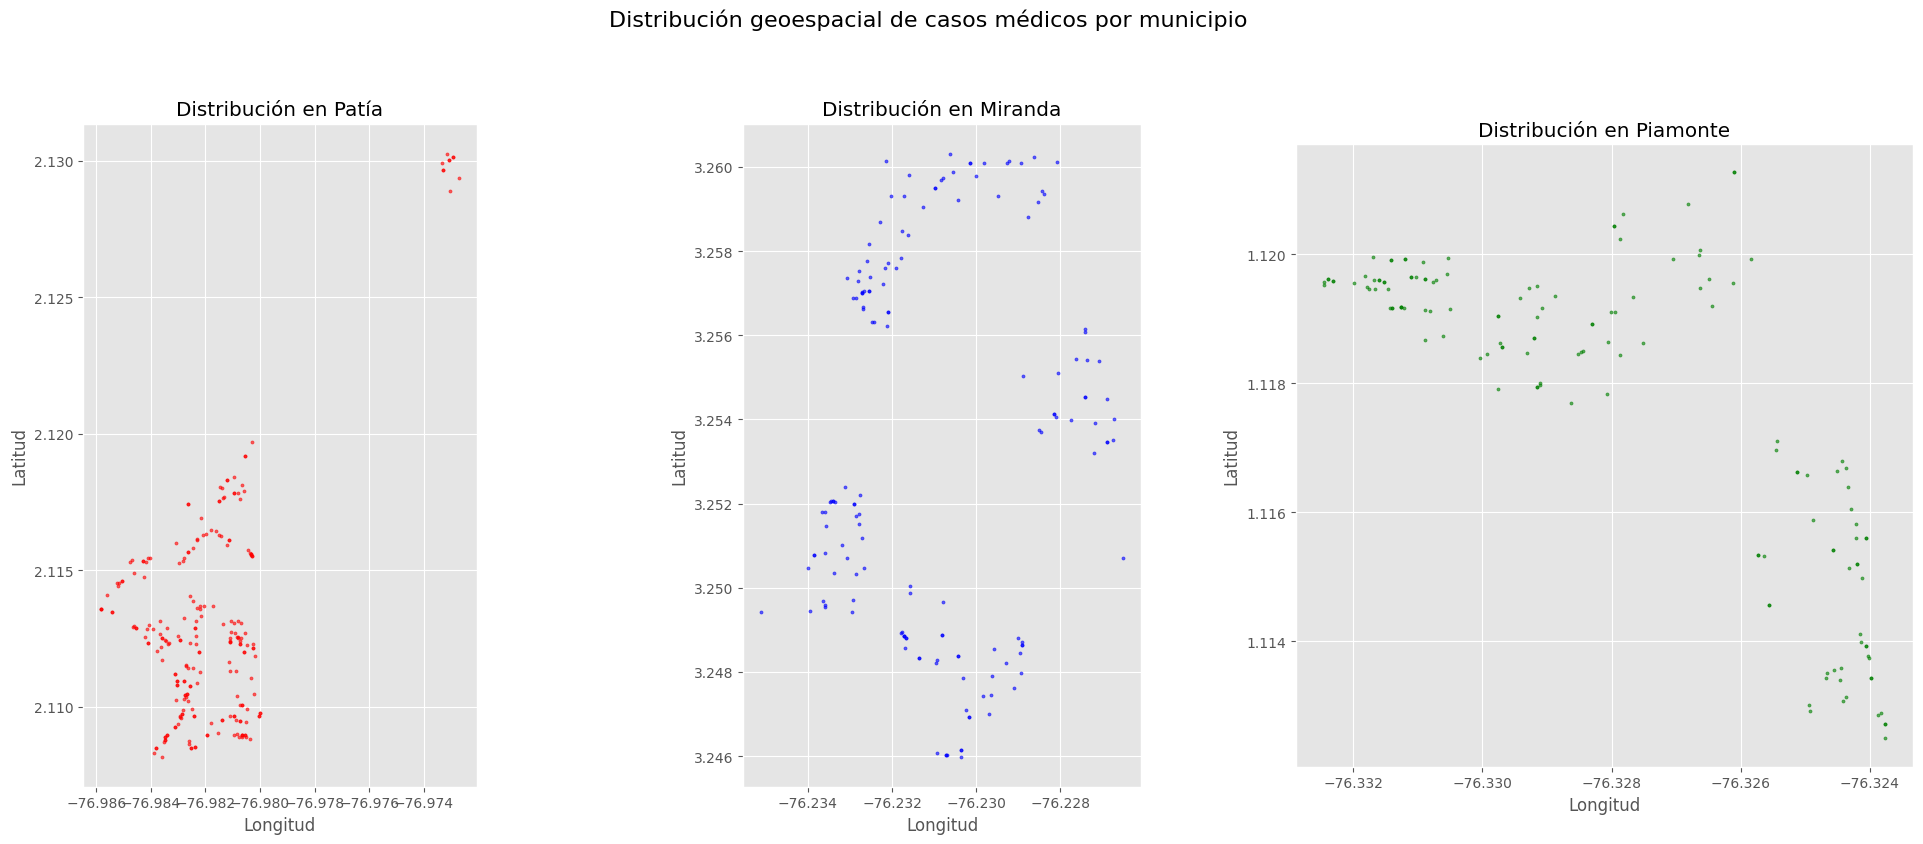

In [64]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Get location data
df_location = df_entomologico[['county', 'decimalLatitude', 'decimalLongitude']]

# Filter by county
df_location_b1 = df_location[df_location['county'] == 'Patía']
df_location_b2 = df_location[df_location['county'] == 'Miranda']
df_location_b3 = df_location[df_location['county'] == 'Piamonte']

# Create GeoDataFrames for each county
gdf_patia = gpd.GeoDataFrame(df_location_b1, geometry=gpd.points_from_xy(df_location_b1.decimalLongitude, df_location_b1.decimalLatitude))
gdf_miranda = gpd.GeoDataFrame(df_location_b2, geometry=gpd.points_from_xy(df_location_b2.decimalLongitude, df_location_b2.decimalLatitude))
gdf_piamonte = gpd.GeoDataFrame(df_location_b3, geometry=gpd.points_from_xy(df_location_b3.decimalLongitude, df_location_b3.decimalLatitude))

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Plot each county in its own subplot
gdf_patia.plot(ax=axes[0], marker='o', color='red', markersize=5, alpha=0.6)
axes[0].set_title('Distribución en Patía')
axes[0].set_xlabel('Longitud')
axes[0].set_ylabel('Latitud')

gdf_miranda.plot(ax=axes[1], marker='o', color='blue', markersize=5, alpha=0.6)
axes[1].set_title('Distribución en Miranda')
axes[1].set_xlabel('Longitud')
axes[1].set_ylabel('Latitud')

gdf_piamonte.plot(ax=axes[2], marker='o', color='green', markersize=5, alpha=0.6)
axes[2].set_title('Distribución en Piamonte')
axes[2].set_xlabel('Longitud')
axes[2].set_ylabel('Latitud')

# Add a main title
fig.suptitle('Distribución geoespacial de casos médicos por municipio', fontsize=16, y=1.05)

# Adjust layout
plt.tight_layout()
plt.show()

### **Visualización de índices de diversidad por barrio**

A continuación se presenta un gráfico comparativo de los índices de Shannon y Simpson para cada barrio estudiado, lo que permite identificar fácilmente las áreas con mayor diversidad de especies.

In [39]:
# # Convertir los índices de string a float para la visualización
# dff_plot = dff.copy()
# dff_plot['Indice de Shannon'] = dff_plot['Indice de Shannon'].astype(float)
# dff_plot['Indice de Simpson'] = dff_plot['Indice de Simpson'].astype(float)

# # Ordenar por índice de Shannon para mejor visualización
# dff_plot = dff_plot.sort_values('Indice de Shannon', ascending=False)

# # Crear el gráfico de barras agrupadas
# fig, ax = plt.subplots(figsize=(12, 7))

# # Definir posiciones para las barras
# x = np.arange(len(dff_plot['Localidad']))
# width = 0.35

# # Crear barras para cada índice
# shannon_bars = ax.bar(x - width/2, dff_plot['Indice de Shannon'], width, label='Índice de Shannon', 
#     color='#1f77b4', alpha=0.8)
# simpson_bars = ax.bar(x + width/2, dff_plot['Indice de Simpson'], width, label='Índice de Simpson', 
#     color='#ff7f0e', alpha=0.8)

# # Añadir etiquetas, título y leyenda
# ax.set_title('Índices de Diversidad por Barrio', fontsize=16, fontweight='bold', pad=20)
# ax.set_xlabel('Barrio', fontsize=14, labelpad=10)
# ax.set_ylabel('Valor del Índice', fontsize=14)
# ax.set_xticks(x)

# # Ajustar etiquetas de ejes para mejor legibilidad
# ax.set_xticklabels(dff_plot['Localidad'], rotation=45, ha='right', fontsize=10)

# # Añadir los valores sobre cada barra
# def add_labels(bars):
#     for bar in bars:
#         height = bar.get_height()
#         ax.annotate(f'{height:.2f}',
#             xy=(bar.get_x() + bar.get_width() / 2, height),
#             xytext=(0, 3),  # 3 puntos de desplazamiento vertical
#             textcoords="offset points",
#             ha='center', va='bottom',
#             fontsize=9, fontweight='bold')

# add_labels(shannon_bars)
# add_labels(simpson_bars)

# # Añadir una línea horizontal para facilitar comparación visual
# ax.axhline(y=dff_plot['Indice de Shannon'].mean(), color='#1f77b4', linestyle='--', alpha=0.5, 
#     label='Media Shannon')
# ax.axhline(y=dff_plot['Indice de Simpson'].mean(), color='#ff7f0e', linestyle='--', alpha=0.5,
#     label='Media Simpson')

# # Añadir anotaciones explicativas
# # Añadir una anotación explicativa en la esquina inferior derecha
# ax.text(0.02, 0.05, 'Mayor valor = Mayor diversidad', transform=ax.transAxes, 
#     fontsize=11, va='bottom', ha='left', 
#     bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

# ax.legend(loc='upper right')
# ax.grid(axis='y', linestyle='--', alpha=0.7)

# # Ajustar diseño
# plt.tight_layout()
# plt.show()

### **Análisis de distribución geográfica detallada**

In [40]:
# import folium
# from folium.plugins import MarkerCluster
# import geopandas as gpd
# import contextily as ctx

# import matplotlib.colors as mcolors
# # Preparar datos de distribución geográfica
# geo_distribution = df.groupby(['decimalLatitude', 'decimalLongitude']).agg({
#     'individualCount': 'sum',
#     'scientificName': 'nunique'
# }).reset_index().rename(columns={'scientificName': 'species_count'})


# # Create a map centered at the mean coordinates
# center = [df['decimalLatitude'].mean(), df['decimalLongitude'].mean()]
# m = folium.Map(location=center, zoom_start=10, tiles='OpenStreetMap')

# # Add a marker cluster to handle many points
# marker_cluster = MarkerCluster().add_to(m)

# # Create a color map for the species
# species_list = df['scientificName'].unique()
# colors = list(plt.cm.tab10.colors)[:len(species_list)]
# species_color_dict = dict(zip(species_list, colors))

# # Add points to the map
# for idx, row in df.iterrows():
#     species = row['scientificName']
#     color = mcolors.rgb2hex(species_color_dict[species])
    
#     # Create popup content
#     popup_content = f"""
#     <b>Species:</b> {row['scientificName']}<br>
#     <b>Count:</b> {row['individualCount']}<br>
#     <b>Locality:</b> {row['locality']}<br>
#     <b>Date:</b> {row['eventDate']}<br>
#     """
    
#     # Add marker
#     folium.CircleMarker(
#         location=[row['decimalLatitude'], row['decimalLongitude']],
#         radius=5 + (row['individualCount'] / 5),  # Size based on count
#         popup=folium.Popup(popup_content, max_width=300),
#         color=color,
#         fill=True,
#         fill_opacity=0.7
#     ).add_to(marker_cluster)

# # Add a legend
# legend_html = '''
# <div style="position: fixed; 
#             bottom: 50px; right: 50px; width: 200px; height: 120px; 
#             background-color: white; border:2px solid grey; z-index:9999; font-size:12px;
#             padding: 10px; border-radius: 5px;">
# <h4>Species Legend</h4>
# '''

# for i, species in enumerate(species_list):
#     color = mcolors.rgb2hex(species_color_dict[species])
#     legend_html += f'<div style="display: flex; align-items: center; margin-bottom: 5px;"><div style="background-color: {color}; width: 15px; height: 15px; margin-right: 5px;"></div>{species}</div>'

# legend_html += '</div>'

# m.get_root().html.add_child(folium.Element(legend_html))

# # Display the map
# m

# # Alternative static plot with geopandas
# fig, ax = plt.subplots(figsize=(12, 10))

# # Create a GeoDataFrame from the points
# gdf = gpd.GeoDataFrame(
#     df, 
#     geometry=gpd.points_from_xy(df.decimalLongitude, df.decimalLatitude),
#     crs="EPSG:4326"
# )

# # Plot with species color coding
# for species, color in species_color_dict.items():
#     subset = gdf[gdf['scientificName'] == species]
#     subset.plot(
#         ax=ax,
#         color=color,
#         label=species,
#         markersize=subset['individualCount']/2,
#         alpha=0.7
#     )

# ax.set_title('Geospatial Distribution of Entomological Samples', fontsize=16)
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# plt.legend()

# # Add basemap
# try:
#     ctx.add_basemap(
#         ax, 
#         crs=gdf.crs.to_string(), 
#         source=ctx.providers.OpenStreetMap.Mapnik
#     )
# except Exception:
#     pass

# plt.tight_layout()
# plt.show()

<Figure size 1000x800 with 0 Axes>

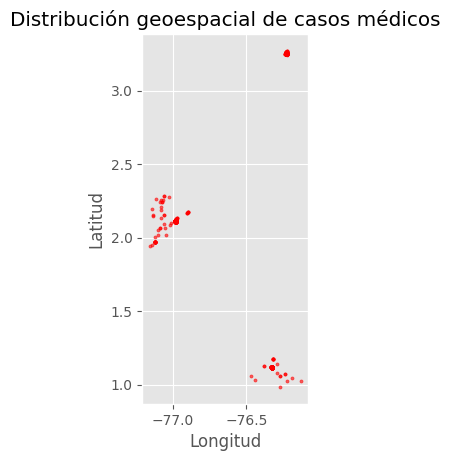

In [41]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

cases_df = pd.read_csv('../data/cases.csv')

cases_gdf = gpd.GeoDataFrame(cases_df, geometry=gpd.points_from_xy(cases_df.Longitud, cases_df.Latitud))

# Plotting the geospatial distribution of cases (scatter plot on a map)
plt.figure(figsize=(10, 8))
cases_gdf.plot(marker='o', color='red', markersize=5, alpha=0.6)
plt.title('Distribución geoespacial de casos médicos')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

La gráfica muestra la distribución geoespacial de los casos médicos, representados por puntos en un plano de latitud y longitud. Cada punto indica una ubicación donde se ha registrado un caso médico.

Interpretación:

- Los puntos rojos representan los casos georreferenciados, y su dispersión en el gráfico indica la ubicación de estos casos en un área geográfica específica (en este caso, parece estar centrada en un sector de Colombia).

- La concentración de puntos en ciertas áreas puede indicar una mayor incidencia de casos en esas regiones.

- Las áreas con pocos o ningún punto pueden reflejar lugares donde los casos son menos frecuentes o donde no se han registrado datos.

Esta información puede ser útil para identificar áreas de alta incidencia, lo que permitiría priorizar intervenciones, recursos médicos o campañas de prevención.

In [42]:
cases_df.head()

,OBJECTID,Loc_name,Longitud,Latitud,Proceso,Match_addr,Barrio_OSM,Sexo,Edad,Ocupación,Pertenencia etnica,fec_consulta,ini_sintomas,locationID,county
0,117,La Paz,-76.329537,1.119479,Georreferenciado,Nombre del Barrio,La Paz,M,11,9999,6,2018-01-24 00:00:00,2018-01-24 00:00:00,CO:19533,Piamonte
1,114,Vereda Trojayaco,-76.273166,0.984080,Georreferenciado,Nombre del Centro Poblado,Trojayaco,M,40,6112,1,2016-01-10 00:00:00,2016-01-07 00:00:00,CO:19533,Piamonte
2,123,Villa Los Prados,-76.327719,1.119409,Georreferenciado,Nombre del Barrio,Villa Los Prados,M,4,9999,6,2018-02-09 00:00:00,2018-02-08 00:00:00,CO:19533,Piamonte
3,116,La Paz,-76.329537,1.119479,Georreferenciado,Nombre del Barrio,La Paz,F,14,9999,6,2018-02-14 00:00:00,2018-02-10 00:00:00,CO:19533,Piamonte
4,133,Villa Los Prados,-76.327719,1.119409,Georreferenciado,Nombre del Barrio,Villa Los Prados,M,7,9999,6,2018-02-09 00:00:00,2018-02-07 00:00:00,CO:19533,Piamonte


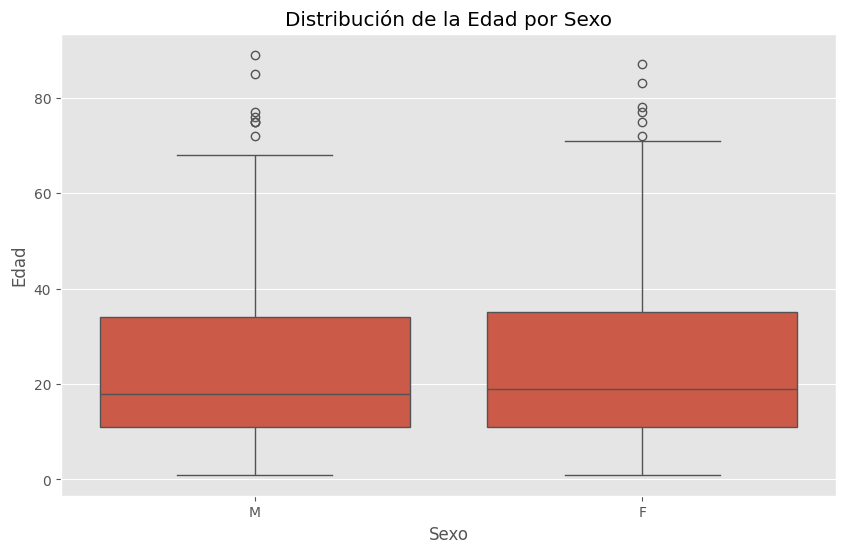

In [43]:

# Analyzing demographic distribution: Age vs Gender
plt.figure(figsize=(10, 6))
sns.boxplot(data=cases_df, x='Sexo', y='Edad')
plt.title('Distribución de la Edad por Sexo')
plt.xlabel('Sexo')
plt.ylabel('Edad')
plt.show()

Number of records with valid dates: 572 out of 573


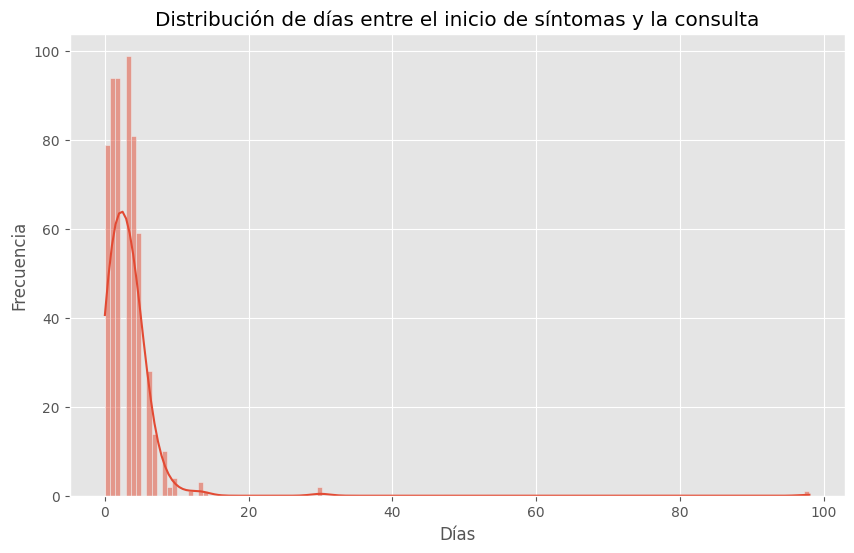

In [44]:

# Temporal analysis: Time between symptoms and consultation (for potential patterns)
# Convert date columns to datetime with error handling
cases_df['fec_consulta'] = pd.to_datetime(cases_df['fec_consulta'], errors='coerce')
cases_df['ini_sintomas'] = pd.to_datetime(cases_df['ini_sintomas'], errors='coerce')

# Drop rows with invalid dates for the temporal analysis
valid_dates = cases_df.dropna(subset=['fec_consulta', 'ini_sintomas'])
print(f"Number of records with valid dates: {len(valid_dates)} out of {len(cases_df)}")
cases_df['ini_sintomas'] = pd.to_datetime(cases_df['ini_sintomas'])
cases_df['days_between_symptoms_and_consultation'] = (cases_df['fec_consulta'] - cases_df['ini_sintomas']).dt.days

# Plotting the distribution of days between symptoms and consultation
plt.figure(figsize=(10, 6))
sns.histplot(cases_df['days_between_symptoms_and_consultation'], kde=True)
plt.title('Distribución de días entre el inicio de síntomas y la consulta')
plt.xlabel('Días')
plt.ylabel('Frecuencia')
plt.show()

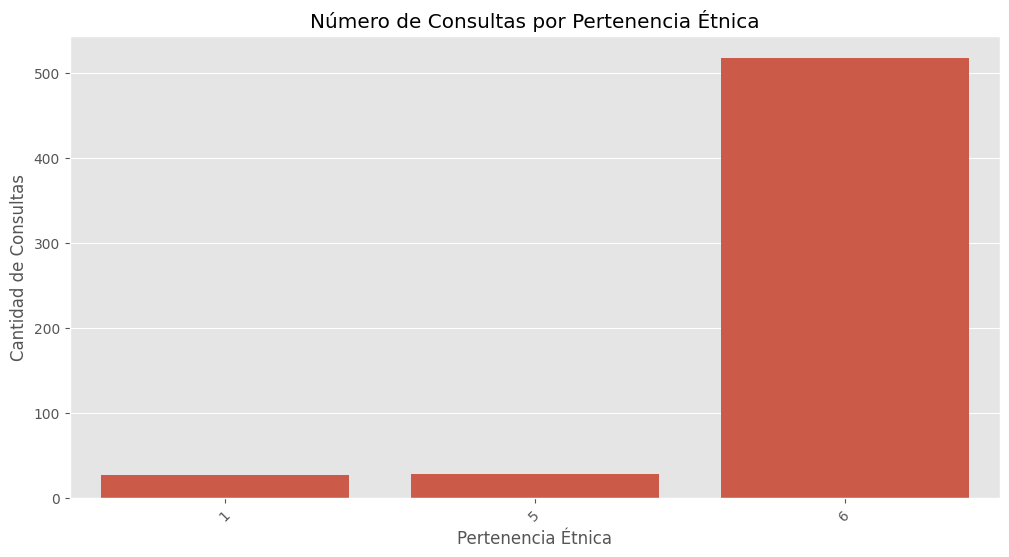

In [45]:


# Correlation between ethnicity and number of consultations
ethnicity_consults = cases_df.groupby('Pertenencia etnica')['OBJECTID'].count().reset_index()
ethnicity_consults.columns = ['Pertenencia etnica', 'Cantidad de Consultas']

# Plotting the correlation between ethnicity and number of consultations
plt.figure(figsize=(12, 6))
sns.barplot(x='Pertenencia etnica', y='Cantidad de Consultas', data=ethnicity_consults)
plt.title('Número de Consultas por Pertenencia Étnica')
plt.xlabel('Pertenencia Étnica')
plt.ylabel('Cantidad de Consultas')
plt.xticks(rotation=45)
plt.show()

In [46]:
# import geopandas as gpd
# import osmnx as ox
# from shapely.geometry import Point, Polygon
# import hvplot.pandas

# # Define the place query
# query = {'city': 'Patia'}

# # Get the boundaries of the place
# try:
#     # Try the newer OSMnx API
#     boundaries = ox.geocode_to_gdf(query)
#     # Add buffer if needed using GeoDataFrame method
#     boundaries['geometry'] = boundaries['geometry'].buffer(0.05)  # ~5km buffer in degrees
# except TypeError:
#     # Fallback method if buffer_dist isn't supported
#     place = ox.geocode_to_gdf(query)
#     # Create buffer manually
#     boundaries = place.copy()
#     boundaries['geometry'] = place['geometry'].buffer(0.05)  # ~5km buffer in degrees

# # Let's check the boundaries on a map
# ax = boundaries.explore(color='red', alpha=0.5)

# boundaries.explore()

In [47]:


# # Create point geometry from coordinates
# df["geometry"] = gpd.points_from_xy(df["decimalLongitude"], df["decimalLatitude"])
# df = gpd.GeoDataFrame(df, crs="epsg:4326")

# # Plot the points on the same map
# df.explore(m=ax, column='scientificName', categorical=True, 
#            legend=True, marker_kwds={'radius': 5})

# # Filter geographically - spatial join with boundaries
# entomological_df = gpd.sjoin(df, boundaries[["geometry"]], predicate='within')
# entomological_df = entomological_df.reset_index(drop=True)

# # Alternative filtering by county name if spatial join doesn't work well
# # entomological_df = df[df['county'] == 'Patía']

# entomological_df.hvplot(geo=True, tiles="OSM", alpha=0.5, width=600, height=600, hover_cols=["name"])